# Data Pipeline Walkthrough

The purpose of this notebook is to demonstrate how the `SegmentationDataset` and `SegmentationDataPipeline` classes can be used to configure a model training pipeline.

In general, there are two major paradigms for loading/preprocessing the data using these classes:
1. "Inline" preprocessing: indicates that the y-labels (i.e. segmentation masks) exist as Run-length Encoded pairs, as they appear in the raw data. In this paradigm, the `tf.data` pipeline is responsible for un-encoding these labels into segmentation masks as part of the data pipeline step.
2. "Pre-emptive" preprocessing: indicates that the y-labels have already been converted into segmentation masks and saved out in `.png` format (see `scripts/prepare_data.py` for details). In this paradigm, the `tf.data` pipeline simply just has to load these images as segmenetation masks to be used during training since the RLE conversion has already been performed.

This notebook walks through the usage of these two paradigms.

In [ ]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from src.data_utils import get_dataset_path


%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Initialize `SegmentationDataset`

The `SegmentationDataset` class provides functionality for loading/preprocessing images and segmentation masks into a format compatible with `tf.data`, as well as functionality for general modeling strategies like train/test splits and over-sampling strategies. 

We initialize this class by specifying paths to the label file, images directory, image size, and desired test set split percentage. Upon initialization, this class automatically splits the data and saves the splits to local attributes `train_imgs` and `test_imgs`. 

**Note:** We have specified a sample weighting strategy here. See section [Configuration for sample weighting](#section_1) below for more details on this option.


In [2]:
DATASET_DIR = get_dataset_path()
IMG_SHAPE = (256, 1600)
ANNOTATIONS_PATH = f"{DATASET_DIR}/train.csv"
TRAIN_IMG_PATH = f"{DATASET_DIR}/train_images"

# instantiate dataset
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    test_size=0.1,
    drop_classes=True,
    sample_weight_strategy="ens",
    sample_weight_ens_beta=0.99,
)

## Data Pipeline Configurations

The following sections demonstrate how to use the data pipelines for "inline" vs. "pre-emptive" preprocessing settings.

### 1. Pipeline with inline preprocessing

#### Get (X, y) sequences for `tf.data` pipeline

In [3]:
# create x/y splits
train_imgs, test_imgs = sd.train_imgs, sd.test_imgs

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="inline")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="inline")

In [4]:
# here we see the X-sequence is composed of a sequence of image paths,
# while the y-sequence is a series of RLE labels
print("X: ", X_test[:2])
print()
print("y: ", y_test[:2])

X:  ['../data/train_images/b2cbd553f.jpg', '../data/train_images/8d0addbbc.jpg']

y:  [(['3', '4'], ['155537 1 155791 3 156046 3 156301 4 156555 6 156810 7 157065 7 157319 9 157574 10 157828 11 158080 15 158333 18 158587 19 158843 19 159098 20 159354 20 159609 20 159865 20 160120 20 160376 19 160632 19 160888 18 161143 18 161399 17 161655 17 161910 18 162166 18 162422 18 162677 18 162933 18 163189 18 163444 19 163700 19 163955 20 164211 19 164466 20 164722 19 164956 3 164977 20 165210 11 165233 20 165464 18 165488 20 165719 23 165744 20 165975 45 166230 46 166486 46 166742 45 166997 46 167253 46 167509 46 167765 46 168020 47 168276 46 168532 46 168787 47 169043 47 169298 48 169553 49 169809 49 170065 49 170321 49 170577 49 170833 49 171090 48 171346 48 171602 48 171858 48 172114 49 172370 49 172626 49 172882 49 173138 49 173395 48 173651 49 173907 49 174163 49 174419 49 174676 48 174932 48 175188 49 175444 49 175701 48 175957 48 176213 47 176470 46 176726 46 176982 45 177238 45 177495 

#### Instantiate `SegmentationDataPipeline` class

The `SegmentationDataPipeline` is a callable utility class for creating `tf.data` pipelines from `SegmentationDataset` sequences. It allows the user to specify various pipeline optimization parameters like batching, prefetching, parallel preprocessing, and shuffling. 

For more info, checkout the TensorFlow documentation on [Optimizing pipeline performance](https://www.tensorflow.org/guide/data_performance).


In [ ]:
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="inline",
    pipeline_options={
        "map_parallel": tf.data.AUTOTUNE,
        "cache": False,
        "shuffle_buffer_size": 25,
        "batch_size": 8,
        "prefetch": tf.data.AUTOTUNE,
    },
)

# create dataset pipelines
train_dataset_inline = sdp(X_train, y_train, is_train=True)
test_dataset_inline = sdp(X_test, y_test, is_train=False)

#### Inspect pipeline output

The pipeline returns batches of shape:
- X: (batch_size, height, width, 3)
- y: (batch_size, height, width, n_channels)

where n_channels is the number of defect classes + a background class. Notice our setup only utilizes two defect classes as a means to simplify the modeling problem.

In [6]:
sample_inline = list(train_dataset_inline.take(1).as_numpy_iterator())

In [7]:
sample_inline[0][0].shape, sample_inline[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 3))

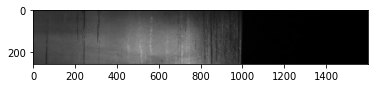

In [8]:
# plot X
plt.imshow(sample_inline[0][0][1])

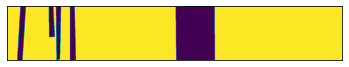

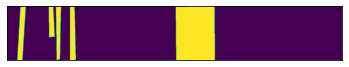

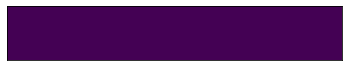

In [9]:
# plot y
for i in range(sample_inline[0][1].shape[-1]):
    fig = plt.figure()
    plt.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )
    plt.imshow(np.expand_dims(sample_inline[0][1][1][..., i], axis=-1))

### 2. Pipeline with pre-emptive preprocessing

#### Get (X, y) sequences for `tf.data` pipeline

In [10]:
# create x/y splits
train_imgs, test_imgs = sd.train_imgs, sd.test_imgs

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

In [11]:
# here see that the X-sequence is still composed of a sequence of image paths,
# while the y-sequence is now also a series of image paths that have been previously saved out
print("X: ", X_test[:2])
print()
print("y: ", y_test[:2])

X:  ['../data/train_images/b2cbd553f.jpg', '../data/train_images/8d0addbbc.jpg']

y:  ['../data/mask_labels/b2cbd553f.png', '../data/mask_labels/8d0addbbc.png']


#### Instantiate `SegmentationDataPipeline` class

In [12]:
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": tf.data.AUTOTUNE,
        "cache": False,
        "shuffle_buffer_size": 25,
        "batch_size": 8,
        "prefetch": tf.data.AUTOTUNE,
    },
)

# create dataset pipelines
train_dataset_pp = sdp(X_train, y_train, is_train=True)
test_dataset_pp = sdp(X_test, y_test, is_train=False)

AUGMENTING!!
Shuffling
Batching
Prefetching
Shuffling
Batching
Prefetching


#### Inspect pipeline output

In [13]:
sample_pp = list(train_dataset_pp.take(1).as_numpy_iterator())

In [14]:
sample_pp[0][0].shape, sample_pp[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 3))

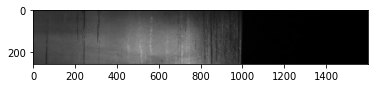

In [15]:
# plot X
plt.imshow(sample_pp[0][0][1])

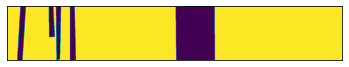

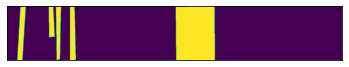

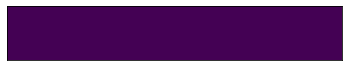

In [16]:
# plot y
for i in range(sample_pp[0][1].shape[-1]):
    fig = plt.figure()
    plt.tick_params(
        left=False, right=False, labelleft=False, labelbottom=False, bottom=False
    )
    plt.imshow(np.expand_dims(sample_pp[0][1][1][..., i], axis=-1))

**Note:** We arrive at the same pipeline output regardless of which pipeline setting we use, inline or pre-emptive preprocessing

<a id="section_1"></a>
## Configuration for sample weighting

Sample weighting is a commonly used technique in imbalanced classification problems that aims to give more weight to examples from rarely-seen classes. To apply sample weighting, we first specify sample weighting strategy as an input when initializing the `SegmentationDataset`. The class automatically calculates and saves a class weight map. Then, we use the mapping to get a sample weight sequence to provide as an argument to our `SegmentationDataPipeline` which allows the weights to be returned in the desired format for a `tf.data` pipeline.



In [17]:
# view the class weight map that will be applied
# see SegmentationDataset._build_class_weight_map() for more details
sd.class_weight_map

{-2: 1.038, 3: 0.9782, 4: 0.9837}

In [18]:
# apply mapping to sequence
train_sample_weights = sd.get_sample_weight_sequence(train_imgs)

In [19]:
# pass the sample
train_dataset_pp = sdp(
    X_train, y_train, is_train=True, sample_weights=train_sample_weights
)

AUGMENTING!!
Shuffling
Batching
Prefetching


In [20]:
# view a sample
sample_pp = list(train_dataset_pp.take(1).as_numpy_iterator())
sample_pp[0][0].shape, sample_pp[0][1].shape, sample_pp[0][2].shape

((8, 256, 1600, 3), (8, 256, 1600, 3), (8, 1))

**Note** - here we see that there is a third data object returned by a pipeline. This is a tensor of sample weights for each sample in the batch.

**If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices. A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).**